**NOTE:** You probably will see warnings. These are not errors! However, you should read them and try to understand why they're there. Can you fix them?

![](http://rentinginla.com/wp-content/uploads/2015/12/Buying.jpg)
# [Project 2: Predicting House Prices with Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

The goal of this project is for you to use EDA, visualization, data cleaning, preprocesing, and linear models to predict home prices given the features of the home, and interpret your linear models to find out what features add value to a home! This project is a bit more open-ended than project 1. 

Be sure to ...

* Think about your choices when it comes to your choices about the data. Be ready to defend your decisions!
* Use lots of plots to dig deeper into the data! Describe the plots and convey what you learned from them.
* Don't forget to read the [description of the data](../data_description.txt) (also available at the kaggle website)! This has valuable information that will help you clean and impute data. `NaN` means something in many of the columns! Don't just drop or fill them!
* Try fitting many models! Document your work and note what you've tried.
* Apply what you've learned in class, books, videos, Kaggle forums, and blog posts. There have been a TON of blog posts about this;  you should seek them out and read them!


From the Kaggle competition website:

    Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

    With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from IPython.display import display

%matplotlib inline 
np.random.seed(42)

## 1. Load the Data 

In [2]:
data = pd.read_csv('/home/jovyan/Project_2_housing/data/train.csv', na_filter = False)

## 2. Exploratory Data Analysis (EDA)

In [3]:
categoric_vars = []
numeric_vars = []
for i in data.columns:
    x = set(data[i])
    if (data[i].dtypes == 'O') | (len(x) < 20):
        categoric_vars.append(i)
        #print(i + ": ")
        #print(x)
    else:
        numeric_vars.append(i)
        #print(i + " is numeric.")

numeric_vars.append(categoric_vars[-8])
categoric_vars.pop(-8)

for i in categoric_vars:
    data[i] = data[i].astype(object)

### A. Data Types

In [4]:
#for i in categoric_vars:
    #print(data[i].value_counts())
    #print("data type is: " + str(data[i].dtype))

Na's in Categorical Features:
`Alley` = 1369 NA's, Not App., i.e. accessed by road not alley.
`MasVnrType` = 8 NA's, not "None" or 'Not App.'
`BsmtQual` & `BsmtCond` = 37. NA here = No Basement.
`BsmtExposure` = 38 NA's, 953 No. No = None, NA = No Basement. Jump in NA #.
`BsmtFinType1` = 37 NA's again, back down. BsmtFinType2 = 38, back up.
`Electrical` = 1 NA, no accom.
`FireplaceQu` = 690 NA's'; NA here = No Fireplace
`GarageType` = 81 NA's, No Garage
`GarageFinish`, `GarageQual`, `GarageCond` = 81 NA's'
`PoolQC` = 1453 NA's, No Pool
`Fence` = 1179 NA's
`MiscFeature` = 1406 NA's

NA's in Numerical Features:
`LotFrontage` : 259 counts; NA implicitly is the result of an NA in the corresponding categorical variable. However, it likely should be imputed into a 0, to signal that there is zero feet of street connected to the property. A similar approach can be found in the PoolArea variable - which for some reason has < 20 unique #'s and thus was categorized as a categorical rather than numeric variable.
`MasVnrArea` : 8; NA is the result of a lack of masonry veneer. Due to the relatively low # of NA's, I simply converted them to a 0.
`GarageYrBlt` : 81; NA is the result of a lack of a garage (see categoric vars above). Due to the fact that 0 would be an inappropriate year assignment and the left-ward skew of the non-Null values, I imputed the mode.

Below, I get convert the NA's in Masonry Veneer Type and Electrical into their mode and 'None' respectively, as these categorical features do not use NA as the standard Null category, unlike the other NA-containing categorical features.

In [5]:
#A bar plot of the NA's is required later. Thus, I am saving them separately here.
na_num_cols = pd.DataFrame()
na_num_cols['LotFrontage'] = data['LotFrontage'] == 'NA'
na_num_cols['MasVnrArea'] = data['MasVnrArea'] == 'NA'
na_num_cols['GarageYrBlt'] = data['GarageYrBlt'] == 'NA'

In [6]:
#troublesome_categoric_columns = ['MasVnrType', 'Electrical']
emode = data['Electrical'].mode()[0]
data['MasVnrType'].replace(to_replace = 'NA', value = 'None', 
                           inplace = True)
data['Electrical'].replace(to_replace = 'NA', value = emode, 
                           inplace = True)

data['Electrical'].mode()[0]

#Replacing NA's in following num_cats w/ appropriate number/statistic.
#Conversion to numeric necessary due to previous state as string-possessing.

#NA of LotFrontage = 0 feet of street connected to property. See PoolArea (cat_var) for similar case.
data['LotFrontage'].replace(to_replace = 'NA', value = 0, inplace = True) #NBDConv'd to frontage-type mean?
data['LotFrontage'] = pd.to_numeric(data['LotFrontage'])

#NA of MVA = 0 feet of mas veneer due to lack of masonry. Converted to 0: only 8 instances.
data['MasVnrArea'].replace(to_replace = 'NA', value = 0, inplace = True)
data['MasVnrArea'] = pd.to_numeric(data['MasVnrArea'])

#NA of GYB = No Garage. Converted to mean due to 0 being an inappropriate date choice.
#And current lack of knowledge r.e. finding the mode.
data['GarageYrBlt'].replace(to_replace = 'NA', value = np.nan, inplace = True)
data['GarageYrBlt'] = pd.to_numeric(data['GarageYrBlt'])#2 year built
data['GarageYrBlt'].replace(to_replace = np.nan, value = np.nanmean(data['GarageYrBlt']), inplace = True)
data['GarageYrBlt'] = pd.to_numeric(data['GarageYrBlt'])#2 year built

### B. Plot histograms of the numeric columns. 

In [7]:
def hist_plot(data = data, col_list = numeric_vars[1:]):
    plt.style.use('seaborn-colorblind'); count = 0;
    fig, axes = plt.subplots(nrows= 4,ncols= int(len(col_list)/4), figsize= (35, 40)) #4by#5
    for row in range(axes.shape[0]):
        for col in range(axes.shape[1]):
            i = col_list[count]; count += 1;
            ax = axes[row][col]
            ax.hist(data[i])
            ax.set_xlabel(i)
    fig.show()
#hist_plot()

#### Observations:

---
Most of the numeric columns tend to hug the left side and skew to the right.
Only YrBuilt, YrRemodAdd, and the year the garage was built tend to hug the right side. 

The year-builts tend to diminish steadily as they skew left (i.e., there are fewer older houses than younger houses at most every level). Year Remod Added, however, vaguely has a slump in the middle but then peaks again on the left.

LotArea is nearly a tower, with only a small amount of houses having larger land.
The same goes for BsmtFinSF2, and the various porch columns. These have a slightly stronger rightward skew, however.

GarageArea is the only column with a near-normal bellcurve shape.


### C. Plot the Numeric Columns Against `SalePrice` using scatter plots.

In [8]:
def scatter_plot(data = data, col_list = numeric_vars):
    plt.style.use('seaborn-colorblind'); count = 0;
    fig, axes = plt.subplots(nrows= 4,ncols= int(len(col_list)/4), figsize= (35, 40)) #4by#5
    for row in range(axes.shape[0]):
        for col in range(axes.shape[1]):
            i = col_list[count]; count += 1;
            ax = axes[row][col]
            ax.scatter(data[i], data['SalePrice'])
            ax.set_xlabel(i)
            ax.set_ylabel('SalePrice')
    fig.show()
#scatter_plot()

#### Observations:

---
Things generally tend toward a bottom-left -> top-right trend.


### D. Use bar plots to plot categorical features against `SalePrice`.

In [9]:
def bar_plot(data = data, col_list = categoric_vars, target = 'SalePrice'):
    plt.style.use('seaborn-colorblind'); count = 0;
    fig, axes = plt.subplots(nrows= 6,ncols= int(len(col_list)/6), figsize= (60, 100)) #4by#5
    for row in range(axes.shape[0]):
        for col in range(axes.shape[1]):
            i = col_list[count]; count += 1;
            ax = axes[row][col]
            x = data.groupby(i)[target]
            x.mean().plot.bar(yerr = x.std(), ax = ax)
            ax.set_xlabel(i)
            ax.set_ylabel(target)
    fig.show()
#bar_plot()

#### Observations:

---



## 3. Preprocessing

### A. Identify and Remove Outliers for `SalePrice`

3937.5 129975.0 214000.0 508087.5 755000 163000.0


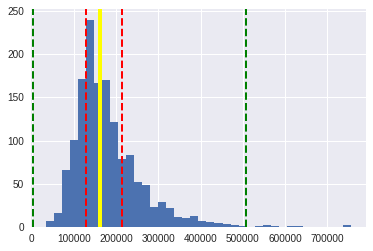

In [10]:
q75, q25 = np.percentile(data['SalePrice'], [75 ,25])
iqr = q75 - q25
fence1 = q25 - iqr*1.5
fence2 = q75 + iqr*3.5

data['SalePrice'].hist(bins = int(np.sqrt(len(data['SalePrice']))))
plt.axvline(q25, color = 'r', \
            linestyle = 'dashed', linewidth = 2)
plt.axvline(q75, color = 'r', \
            linestyle = 'dashed', linewidth = 2)
plt.axvline(fence1, color = 'g', \
            linestyle = 'dashed', linewidth = 2)
plt.axvline(fence2, color = 'g', \
            linestyle = 'dashed', linewidth = 2)
plt.axvline(np.median(data['SalePrice']), color = 'yellow', \
            linestyle = 'solid', linewidth = 4)
print(fence1, q25, q75, fence2, data['SalePrice'].max(), data['SalePrice'].median())

Based on the natural right-ward skew of the histogram and the way that a fairly large amount of data would become labeled as an outlier by Tukey's method, I feel that using it to determine outliers is inappropriate for this feature.

I thought of doing a KNN Classifier to determine outliers at some point, but ended up giving up on the idea. So, eyeballing things, the right fencepost for what can be considered an outlier need to be around 2 times more to the right to account for this feature's rightward skew. So I'll multiply that side by 3.5 rather than 1.5.

In [11]:
SP_outlier_mask = (q25 - iqr*1.5 < data['SalePrice']) \
& (data['SalePrice'] < q75 + iqr*3.5)
print('As we can see here, this leaves approximately ' + str(sum(-SP_outlier_mask)) +\
' points outside of our bounds, and thus marked outliers.')

As we can see here, this leaves approximately 8 points outside of our bounds, and thus marked outliers.


In [12]:
data['SalePrice'].mask(-SP_outlier_mask, data[SP_outlier_mask]['SalePrice'].median(),\
                       inplace = True)
data[-SP_outlier_mask]['SalePrice']

440     162700
691     162700
769     162700
803     162700
898     162700
1046    162700
1169    162700
1182    162700
Name: SalePrice, dtype: int64

I chose to replace these outlier values with the median saleprice in order to retain the data.

The median was chosen due to the skew of the feature.

### B. Fill missing data!
  

Categorical_variables
`Alley` = 1369 NA's, Not App., i.e. accessed by road not alley.
`MasVnrType` = 8 NA's, not "None" or 'Not App.'
`BsmtQual` & `BsmtCond` = 37. NA here = No Basement.
`BsmtExposure` = 38 NA's, 953 No. No = None, NA = No Basement. Jump in NA #.
`BsmtFinType1` = 37 NA's again, back down. BsmtFinType2 = 38, back up.
`Electrical` = 1 NA, no accom.
`FireplaceQu` = 690 NA's'; NA here = No Fireplace
`GarageType` = 81 NA's, No Garage
`GarageFinish`, `GarageQual`, `GarageCond` = 81 NA's'
`PoolQC` = 1453 NA's, No Pool
`Fence` = 1179 NA's
`MiscFeature` = 1406 NA's

#Numeric_variables w/ NA's
`LotFrontage` : 259 counts; NA implicitly is the result of an NA in the corresponding categorical variable. However, it likely should be imputed into a 0, to signal that there is zero feet of street connected to the property. A similar approach can be found in the PoolArea variable - which for some reason has < 20 unique #'s and thus was categorized as a categorical rather than numeric variable.
`MasVnrArea` : 8; NA is the result of a lack of masonry veneer. Due to the relatively low # of NA's, I simply converted them to a 0.
`GarageYrBlt` : 81; NA is the result of a lack of a garage (see categoric vars above). Due to the fact that 0 would be an inappropriate year assignment and the left-ward skew of the non-Null values, I imputed the mode.

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


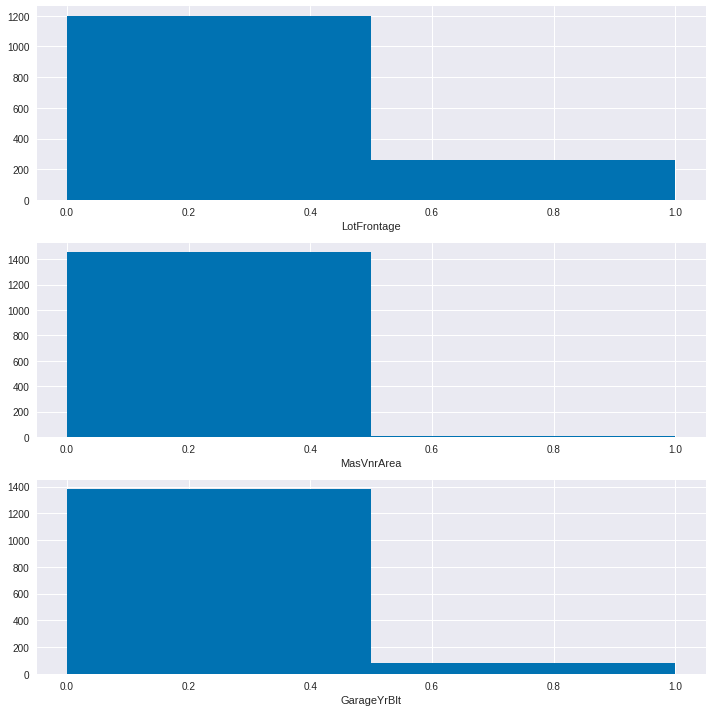

In [13]:
na_num_cols.hist #True = 'NA', False = !'NA'

plt.style.use('seaborn-colorblind'); count = 0;
fig, axes = plt.subplots(nrows= 3, figsize= (10, 10))
for col in range(axes.shape[0]):
    i = na_num_cols.columns[count]; count += 1;
    ax = axes[col]
    ax.hist(na_num_cols[i], bins = 2)
    ax.set_xlabel(i)
fig.tight_layout()
fig.show()

In [14]:
#troublesome_categoric_columns = ['MasVnrType', 'Electrical']
emode = data['Electrical'].mode()[0]
data['MasVnrType'].replace(to_replace = 'NA', value = 'None', 
                           inplace = True)
data['Electrical'].replace(to_replace = 'NA', value = emode, 
                           inplace = True)

data['Electrical'].mode()[0]

#Replacing NA's in following num_cats w/ appropriate number/statistic.
#Conversion to numeric necessary due to previous state as string-possessing.

#NA of LotFrontage = 0 feet of street connected to property. See PoolArea (cat_var) for similar case.
data['LotFrontage'].replace(to_replace = 'NA', value = 0, inplace = True) #NBDConv'd to frontage-type mean?
data['LotFrontage'] = pd.to_numeric(data['LotFrontage'])

#NA of MVA = 0 feet of mas veneer due to lack of masonry. Converted to 0: only 8 instances.
data['MasVnrArea'].replace(to_replace = 'NA', value = 0, inplace = True)
data['MasVnrArea'] = pd.to_numeric(data['MasVnrArea'])

#NA of GYB = No Garage. Converted to mean due to 0 being an inappropriate date choice.
#And current lack of knowledge r.e. finding the mode.
data['GarageYrBlt'].replace(to_replace = 'NA', value = np.nan, inplace = True)
data['GarageYrBlt'] = pd.to_numeric(data['GarageYrBlt'])#2 year built
data['GarageYrBlt'].replace(to_replace = np.nan, value = np.nanmean(data['GarageYrBlt']), inplace = True)
data['GarageYrBlt'] = pd.to_numeric(data['GarageYrBlt'])#2 year built

In [15]:
all(data.isnull() == False)

True

### C. Create dummy variables for categorical columns

In [16]:
df = pd.get_dummies(data)
df.shape

(1460, 388)

In [17]:
data.shape

(1460, 81)

### D. Split your data into a train and test set.

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
y = df['SalePrice']
X = df.drop('SalePrice', axis = 1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state = 42)

In [21]:
'SalePrice' in y_train, 'SalePrice' in X_train, 'SalePrice' in X

(False, False, False)

### E. Scale the data

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
data.shape, df.shape, X_train_scaled.shape, y_train.shape, X_test_scaled.shape, y_test.shape

((1460, 81), (1460, 388), (1314, 387), (1314,), (146, 387), (146,))

## 4. Modeling

### A. Benchmarking

In [25]:
from sklearn.linear_model import LinearRegression

In [26]:
results = list()

#### Raw Benchmark

Instantiate a new `LinearRegression` model and save it as `benchmark_raw`.

In [27]:
def pseudo_pipeline(name = 'benchmark', model = LinearRegression(),\
                    X_train = X_train, y_train = y_train, \
                    X_test = X_test, y_test = y_test, \
                    scaler = StandardScaler(), results = results):
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model.fit(X_train, y_train)
    raw_train_score = model.score(X_train, y_train)
    raw_test_score = model.score(X_test, y_test)
    
    model_scaled = model.fit(X_train_scaled, y_train)
    scaled_train_score = model_scaled.score(X_train_scaled, y_train)
    scaled_test_score = model_scaled.score(X_test_scaled, y_test)
    
    results.append({'name': name,
                'model': model,
                'dataset' : 'train',
                'preprocessing': 'raw',
                'score': raw_train_score})
    results.append({'name': name,
                'model': model,
                'dataset' : 'test',
                'preprocessing': 'raw',
                'score': raw_test_score})
    results.append({'name': name,
                'model': model,
                'dataset' : 'train',
                'preprocessing': 'scaled',
                'score': scaled_train_score})
    results.append({'name': name,
                'model': model,
                'dataset' : 'test',
                'preprocessing': 'scaled',
                'score': scaled_test_score})
    return results, model, model_scaled
#results, model, model_scaled = pseudo_pipeline()

In [28]:
benchmark_raw = LinearRegression()

In [29]:
benchmark_raw.fit(X_train, y_train)
raw_train_score = benchmark_raw.score(X_train, y_train)
raw_test_score = benchmark_raw.score(X_test, y_test)

results.append({'name':'benchmark',
                'model':benchmark_raw,
                'dataset' : 'train',
                'preprocessing': 'raw',
                'score': raw_train_score})
results.append({'name':'benchmark',
                'model':benchmark_raw,
                'dataset' : 'test',
                'preprocessing': 'raw',
                'score': raw_test_score})

In [30]:
np.abs(benchmark_raw.coef_).max()

354055.90425392112

#### Scaled Benchmark

In [31]:
benchmark_scaled = LinearRegression()

In [32]:
benchmark_scaled.fit(X_train_scaled, y_train)
scaled_train_score = benchmark_scaled.score(X_train_scaled, y_train)
scaled_test_score = benchmark_scaled.score(X_test_scaled, y_test)

results.append({'name':'benchmark',
                'model':benchmark_scaled,
                'dataset' : 'train',
                'preprocessing': 'scaled',
                'score': scaled_train_score})
results.append({'name':'benchmark',
                'model':benchmark_scaled,
                'dataset' : 'test',
                'preprocessing': 'scaled',
                'score': scaled_test_score})

In [64]:
results

[{'dataset': 'train',
  'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  'name': 'benchmark',
  'preprocessing': 'raw',
  'score': 0.91423359392587056},
 {'dataset': 'test',
  'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  'name': 'benchmark',
  'preprocessing': 'raw',
  'score': 0.68281732503287451},
 {'dataset': 'train',
  'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  'name': 'benchmark',
  'preprocessing': 'scaled',
  'score': 0.91337039026362055},
 {'dataset': 'test',
  'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  'name': 'benchmark',
  'preprocessing': 'scaled',
  'score': -2.3180874962681509e+24},
 {'dataset': 'train',
  'model': Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
     normalize=False, random_state=None, solver='auto', tol=0.001),
  'name': 'ridge',
  'preprocessing': 'raw',
  'score'

#### What are your observations? Add them to this markdown cell.


It does much better on the training data. The last score is negative, which means it's exceedingly bad.

I had a similar issue later on in this project, but that was due to predicting scaled data using a model fit to unscaled data. Since that score was predicted using a model fit to scaled data, I have no idea why it occurred.

### B. Naive Regularization

Next, prepare a series of fits using the three regularized linear regression models with their default settings against both the raw and the scaled data.
**NOTE:** By "naive" we mean using all of the default settings.

In [33]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score

In [34]:
ridge = Ridge()
ridge.fit(X_train, y_train)
scaled_ridge = Ridge()
scaled_ridge.fit(X_train_scaled, y_train)

results.append({'name':'ridge',
                'model':ridge,
                'dataset' : 'train',
                'preprocessing': 'raw',
                'score': ridge.score(X_train, y_train)})
results.append({'name':'ridge',
                'model':ridge,
                'dataset' : 'test',
                'preprocessing': 'raw',
                'score': ridge.score(X_test, y_test)})
results.append({'name':'ridge',
                'model':scaled_ridge,
                'dataset' : 'train',
                'preprocessing': 'scaled',
                'score': scaled_ridge.score(X_train_scaled, y_train)})
results.append({'name':'ridge',
                'model':scaled_ridge,
                'dataset' : 'test',
                'preprocessing': 'scaled',
                'score': scaled_ridge.score(X_test_scaled, y_test)})

In [35]:
lasso = Lasso()
lasso.fit(X_train, y_train)
scaled_lasso = Lasso()
scaled_lasso.fit(X_train_scaled, y_train)

results.append({'name':'lasso',
                'model':lasso,
                'dataset' : 'train',
                'preprocessing': 'raw',
                'score': lasso.score(X_train, y_train)})
results.append({'name':'lasso',
                'model':lasso,
                'dataset' : 'test',
                'preprocessing': 'raw',
                'score': lasso.score(X_test, y_test)})
results.append({'name':'lasso',
                'model':scaled_lasso,
                'dataset' : 'train',
                'preprocessing': 'scaled',
                'score': scaled_lasso.score(X_train_scaled, y_train)})
results.append({'name':'lasso',
                'model':scaled_lasso,
                'dataset' : 'test',
                'preprocessing': 'scaled',
                'score': scaled_lasso.score(X_test_scaled, y_test)})

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [36]:
en = ElasticNet()
en.fit(X_train, y_train)
scaled_en = ElasticNet()
scaled_en.fit(X_train_scaled, y_train)

results.append({'name':'en',
                'model':en,
                'dataset' : 'train',
                'preprocessing': 'raw',
                'score': en.score(X_train, y_train)})
results.append({'name':'en',
                'model':en,
                'dataset' : 'test',
                'preprocessing': 'raw',
                'score': en.score(X_test, y_test)})
results.append({'name':'en',
                'model':scaled_en,
                'dataset' : 'train',
                'preprocessing': 'scaled',
                'score': scaled_en.score(X_train_scaled, y_train)})
results.append({'name':'en',
                'model':scaled_en,
                'dataset' : 'test',
                'preprocessing': 'scaled',
                'score': scaled_en.score(X_test_scaled, y_test)})

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Note that we see warnings here. As we are in an exploration phase with our model, this is acceptable.

Use a DataFrame to store your `results` as `results_df`. By this we mean, save the `results` list into a new dataframe so that you can manipulate the DataFrame.

In [37]:
results_df = pd.DataFrame(results)

#### Display just the raw test results using pandas

In [38]:
results_df[results_df['preprocessing'] == 'raw']

,dataset,model,name,preprocessing,score
0,train,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,raw,0.914234
1,test,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,raw,0.682817
4,train,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",ridge,raw,0.903487
5,test,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",ridge,raw,0.697926
8,train,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",lasso,raw,0.914182
9,test,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",lasso,raw,0.685020
12,train,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",en,raw,0.782714
13,test,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",en,raw,0.750094


#### What are your observations? Add them to this markdown cell.

---



#### Display just the scaled test results

In [39]:
results_df[(results_df.preprocessing == 'scaled') & (results_df.dataset == 'test')]

,dataset,model,name,preprocessing,score
3,test,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,scaled,-2.318087e+24
7,test,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",ridge,scaled,6.836137e-01
11,test,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",lasso,scaled,6.836022e-01
15,test,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",en,scaled,7.257364e-01


#### What are your observations? Add them to this markdown cell.

---



#### Display just the Benchmark models

In [40]:
results_df[results_df.name == 'benchmark']

,dataset,model,name,preprocessing,score
0,train,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,raw,9.142336e-01
1,test,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,raw,6.828173e-01
2,train,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,scaled,9.133704e-01
3,test,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,scaled,-2.318087e+24


#### Display just the Ridge models

In [41]:
results_df[(results_df.name == 'ridge')]

,dataset,model,name,preprocessing,score
4,train,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",ridge,raw,0.903487
5,test,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",ridge,raw,0.697926
6,train,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",ridge,scaled,0.914226
7,test,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",ridge,scaled,0.683614


#### Display just the Lasso models

In [42]:
results_df[(results_df.name == 'lasso')]

,dataset,model,name,preprocessing,score
8,train,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",lasso,raw,0.914182
9,test,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",lasso,raw,0.685020
10,train,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",lasso,scaled,0.914233
11,test,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",lasso,scaled,0.683602


#### Display just the Elasticnet models

In [43]:
results_df[(results_df.name == 'en')]

,dataset,model,name,preprocessing,score
12,train,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",en,raw,0.782714
13,test,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",en,raw,0.750094
14,train,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",en,scaled,0.886074
15,test,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",en,scaled,0.725736


#### What are your observations? Add them to this markdown cell.

---



### C. Cross-validated models

Import the Cross-Validation Models for each of the Regularized Linear Models

In [44]:
cv_results = list()

In [45]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

Perform the cross-validation using an `np.logspace(-2,4,7)`.

In [46]:
a = np.logspace(-2, 4, 7)

In [47]:
ridgecv = RidgeCV(alphas=a, cv=5)
ridgecv.fit(X_train, y_train)
scaled_ridgecv = RidgeCV(alphas=a, cv=5)
scaled_ridgecv.fit(X_train_scaled, y_train)

cv_results.append({'name':'ridge',
                'model':ridgecv,
                'dataset' : 'train',
                'preprocessing': 'raw',
                'score': ridgecv.score(X_train, y_train)})
cv_results.append({'name':'ridge',
                'model':ridgecv,
                'dataset' : 'test',
                'preprocessing': 'raw',
                'score': ridgecv.score(X_test, y_test)})
cv_results.append({'name':'ridge',
                'model':scaled_ridgecv,
                'dataset' : 'train',
                'preprocessing': 'scaled',
                'score': scaled_ridgecv.score(X_train_scaled, y_train)})
cv_results.append({'name':'ridge',
                'model':scaled_ridgecv,
                'dataset' : 'test',
                'preprocessing': 'scaled',
                'score': scaled_ridgecv.score(X_test_scaled, y_test)})

In [48]:
lassocv = LassoCV(alphas=a, cv=5)
lassocv.fit(X_train, y_train)
scaled_lassocv = LassoCV(alphas=a, cv=5)
scaled_lassocv.fit(X_train_scaled, y_train)

cv_results.append({'name':'lasso',
                'model':lassocv,
                'dataset' : 'train',
                'preprocessing': 'raw',
                'score': lassocv.score(X_train, y_train)})
cv_results.append({'name':'lasso',
                'model':lassocv,
                'dataset' : 'test',
                'preprocessing': 'raw',
                'score': lassocv.score(X_test, y_test)})
cv_results.append({'name':'lasso',
                'model':scaled_lassocv,
                'dataset' : 'train',
                'preprocessing': 'scaled',
                'score': scaled_lassocv.score(X_train_scaled, y_train)})
cv_results.append({'name':'lasso',
                'model':scaled_lassocv,
                'dataset' : 'test',
                'preprocessing': 'scaled',
                'score': scaled_lassocv.score(X_test_scaled, y_test)})

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [49]:
encv = ElasticNetCV(l1_ratio=[.25,.5,.75], cv=5)
encv.fit(X_train, y_train)
scaled_encv = ElasticNetCV(l1_ratio=[.25,.5,.75], cv=5)
scaled_encv.fit(X_train_scaled, y_train)

cv_results.append({'name':'en',
                'model':encv,
                'dataset' : 'train',
                'preprocessing': 'raw',
                'score': encv.score(X_train, y_train)})
cv_results.append({'name':'en',
                'model':encv,
                'dataset' : 'test',
                'preprocessing': 'raw',
                'score': encv.score(X_test, y_test)})
cv_results.append({'name':'en',
                'model':scaled_encv,
                'dataset' : 'train',
                'preprocessing': 'scaled',
                'score': scaled_encv.score(X_train_scaled, y_train)})
cv_results.append({'name':'en',
                'model':scaled_encv,
                'dataset' : 'test',
                'preprocessing': 'scaled',
                'score': scaled_encv.score(X_test_scaled, y_test)})

#### Display just the raw test results

In [50]:
cv_results_df = pd.DataFrame(cv_results)

In [51]:
cv_results_df[(results_df.preprocessing == 'raw') & (results_df.dataset == 'test')]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,dataset,model,name,preprocessing,score
1,test,"RidgeCV(alphas=array([ 1.00000e-02, 1.00000...",ridge,raw,0.736981
5,test,"LassoCV(alphas=array([ 1.00000e-02, 1.00000...",lasso,raw,0.727734
9,test,"ElasticNetCV(alphas=None, copy_X=True, cv=5, e...",en,raw,0.602617


#### Display just the scaled test results

In [52]:
cv_results_df[(results_df.preprocessing == 'scaled') & (results_df.dataset == 'test')]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,dataset,model,name,preprocessing,score
3,test,"RidgeCV(alphas=array([ 1.00000e-02, 1.00000...",ridge,scaled,0.734095
7,test,"LassoCV(alphas=array([ 1.00000e-02, 1.00000...",lasso,scaled,0.712513
11,test,"ElasticNetCV(alphas=None, copy_X=True, cv=5, e...",en,scaled,0.594769


### D. Model Selection

Interpret Regression Metrics for each of your models. Choose one of the following:

* R2
* MSE / RMSE
* MAE

What are your top 3 performing models? 

Find R2 via:
y_pred_~ = ~.fit(X_train, y_train).predict(X_test)
r2_score_~ = r2_score(y_test, y_pred_~)

Find MSE via
~cv.mse_paths.

Find MAE via:
y_pred_~ = ~.fit(X_train, y_train).predict(X_test)
mae_score = mean_absolute_error(y_true, y_pred_~)

RMSE & MAE: "Taking the square root of the average squared errors has some interesting implications for RMSE. Since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors. This means the RMSE should be more useful when large errors are particularly undesirable. The three tables below show examples where MAE is steady and RMSE increases as the variance associated with the frequency distribution of error magnitudes also increases."
"Here is another situation when you want to use (R)MSE instead of MAE: when your observations' conditional distribution is asymmetric and you want an unbiased fit. The (R)MSE is minimized by the conditional mean, the MAE by the conditional median. So if you minimize the MAE, the fit will be closer to the median and biased."

RMSE > MAE for datasets lacking in large errors or when large errors are undesirable. MAE is a good baseline for skewed data due to its use of the median, but is worse across datasets due to its bias.

R2 is unbiased, and measures variability well. It's what the various models we're making use natively, which means it is probably the industry standard. It has an elegant formula, which incidentally is very similar to MSE, and I just like it the best. So I will use R2.

In [53]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
def find_r2(fitted_model, X_test = [X_test, X_test_scaled], y_test = y_test):
    y_pred = [fitted_model.predict(X_test[0]), fitted_model.predict(X_test[1])]
    r2score = [r2_score(y_test, y_pred[0]), r2_score(y_test, y_pred[1])]
    return max(r2score)
def find_mae(fitted_model, X_test = [X_test, X_test_scaled], y_test = y_test):
    y_pred = [fitted_model.predict(X_test[0]), fitted_model.predict(X_test[1])]
    maescore = [mean_absolute_error(y_test, y_pred[0]), mean_absolute_error(y_test, y_pred[1])]
    return min(maescore)
def find_mse(fitted_model, X_test = [X_test, X_test_scaled], y_test = y_test):
    y_pred = [fitted_model.predict(X_test[0]), fitted_model.predict(X_test[1])]
    msescore = [mean_squared_error(y_test, y_pred[0]), mean_squared_error(y_test, y_pred[1])]
    return min(msescore)
def find_rmse(fitted_model, X_test = [X_test, X_test_scaled], y_test = y_test):
    y_pred = [fitted_model.predict(X_test[0]), fitted_model.predict(X_test[1])]
    rmsescore = [np.sqrt(mean_squared_error(y_test, y_pred[0])), np.sqrt(mean_squared_error(y_test, y_pred[1]))]
    return min(rmsescore)
print(find_r2(encv))
print(find_mae(encv))
print(find_mse(encv))
print(find_rmse(encv))

0.602617250639
29875.8780347
2221381947.18
47131.5387738


In [54]:
cv_results_df['r2_score'] = cv_results_df['model'].apply(find_r2)
cv_results_df['mae_score'] = cv_results_df['model'].apply(find_mae)
cv_results_df['mse_score'] = cv_results_df['model'].apply(find_mse)
cv_results_df['rmse_score'] = cv_results_df['model'].apply(find_rmse)

In [68]:
cv_results_df

,dataset,model,name,preprocessing,score,r2_score,mae_score,mse_score,rmse_score
0,train,"RidgeCV(alphas=array([ 1.00000e-02, 1.00000...",ridge,raw,0.883630,0.736981,20098.231806,1.470287e+09,38344.324104
1,test,"RidgeCV(alphas=array([ 1.00000e-02, 1.00000...",ridge,raw,0.736981,0.736981,20098.231806,1.470287e+09,38344.324104
2,train,"RidgeCV(alphas=array([ 1.00000e-02, 1.00000...",ridge,scaled,0.876348,0.734095,20274.830549,1.486417e+09,38554.076902
3,test,"RidgeCV(alphas=array([ 1.00000e-02, 1.00000...",ridge,scaled,0.734095,0.734095,20274.830549,1.486417e+09,38554.076902
4,train,"LassoCV(alphas=array([ 1.00000e-02, 1.00000...",lasso,raw,0.881384,0.727734,19466.019035,1.521975e+09,39012.497335
5,test,"LassoCV(alphas=array([ 1.00000e-02, 1.00000...",lasso,raw,0.727734,0.727734,19466.019035,1.521975e+09,39012.497335
6,train,"LassoCV(alphas=array([ 1.00000e-02, 1.00000...",lasso,scaled,0.883889,0.712513,18453.211976,1.607060e+09,40088.154505
7,test,"LassoCV(alphas=array([ 1.00000e-02, 1.00000...",lasso,scaled,0.712513,0.712513,18453.211976,1.607060e+09,40088.154505
8,train,"ElasticNetCV(alphas=None, copy_X=True, cv=5, e...",en,raw,0.588604,0.602617,29875.878035,2.221382e+09,47131.538774
9,test,"ElasticNetCV(alphas=None, copy_X=True, cv=5, e...",en,raw,0.602617,0.602617,29875.878035,2.221382e+09,47131.538774


In [69]:
cv_results_df2 = cv_results_df[cv_results_df['dataset'] == 'test']
cv_results_df2

,dataset,model,name,preprocessing,score,r2_score,mae_score,mse_score,rmse_score
1,test,"RidgeCV(alphas=array([ 1.00000e-02, 1.00000...",ridge,raw,0.736981,0.736981,20098.231806,1.470287e+09,38344.324104
3,test,"RidgeCV(alphas=array([ 1.00000e-02, 1.00000...",ridge,scaled,0.734095,0.734095,20274.830549,1.486417e+09,38554.076902
5,test,"LassoCV(alphas=array([ 1.00000e-02, 1.00000...",lasso,raw,0.727734,0.727734,19466.019035,1.521975e+09,39012.497335
7,test,"LassoCV(alphas=array([ 1.00000e-02, 1.00000...",lasso,scaled,0.712513,0.712513,18453.211976,1.607060e+09,40088.154505
9,test,"ElasticNetCV(alphas=None, copy_X=True, cv=5, e...",en,raw,0.602617,0.602617,29875.878035,2.221382e+09,47131.538774
11,test,"ElasticNetCV(alphas=None, copy_X=True, cv=5, e...",en,scaled,0.594769,0.594769,35108.418951,2.265254e+09,47594.687172


In [78]:
best_r2 = cv_results_df2.sort_values('r2_score', ascending = False).head(1)
best_mae = cv_results_df2.sort_values('mae_score', ascending = True).head(1)
best_mse = cv_results_df2.sort_values('mse_score', ascending = True).head(1)
best_rmse = cv_results_df2.sort_values('rmse_score', ascending = True).head(1)

In [79]:
best_r2

,dataset,model,name,preprocessing,score,r2_score,mae_score,mse_score,rmse_score
1,test,"RidgeCV(alphas=array([ 1.00000e-02, 1.00000...",ridge,raw,0.736981,0.736981,20098.231806,1.470287e+09,38344.324104


In [80]:
best_mae

,dataset,model,name,preprocessing,score,r2_score,mae_score,mse_score,rmse_score
7,test,"LassoCV(alphas=array([ 1.00000e-02, 1.00000...",lasso,scaled,0.712513,0.712513,18453.211976,1.607060e+09,40088.154505


In [81]:
best_mse

,dataset,model,name,preprocessing,score,r2_score,mae_score,mse_score,rmse_score
1,test,"RidgeCV(alphas=array([ 1.00000e-02, 1.00000...",ridge,raw,0.736981,0.736981,20098.231806,1.470287e+09,38344.324104


In [82]:
best_rmse

,dataset,model,name,preprocessing,score,r2_score,mae_score,mse_score,rmse_score
1,test,"RidgeCV(alphas=array([ 1.00000e-02, 1.00000...",ridge,raw,0.736981,0.736981,20098.231806,1.470287e+09,38344.324104


## Explain the bias / variance tradeoff

Why do regularized models perform better on your test set?

Bias is, roughly, how appropriate the complexity of your model is for the data that you are dealing with. If your bias is high, your model is likely insufficiently complex.

Variance is, roughly, how much variation there will be between a pair of models that you create when you fit them to different samples of the relevant data. Often, more flexible models - which are more complex - are also higher in variance.

The goal is thus to make a sufficiently complex (i.e. low in bias) model which is still low in variance. Ideally, one will make a model which has the perfect amount of complexity for the dataset at hand. If so, it will generally predict well and won't vary significantly if refitted for new data because the trend of the data it's fitted to will match the original data's trend.

Regularized models perform better on your test set than unregularized models because their variance is reduced. This variance occurs due to overfitting to the original dataset - i.e. they're made with too much sensitivity to all of the variations in the dataset. Regularizing the model that results from this will generally keep the trends, the gist of what the data is saying. Generally speaking, this occurs by reducing the attention paid to some features or eliminating them entirely. An article I read described regularizing as hitting your computer with a hammer so that it's stupid enough that it can only retain the things that actually matter. A more cliched way of looking at it is that regularization is helping someone see the forest from the trees.

### Interpreting coefficients

For your best model, 

* plot relevant coefficients using the `plot_coef` functoin.


In [75]:
def plot_coef(model, top_n = 10):
    '''
    Plots the magnitude of top and bottom n coefficients
    '''
    cols = X_train.columns
    coef = model.coef_
    zipped = list(zip(cols, coef))
    zipped.sort(key=lambda x: x[1], reverse = True)
    top_10 = pd.DataFrame(zipped).head(top_n)
    bottom_10 = pd.DataFrame(zipped).tail(top_n)
    return pd.concat([top_10, bottom_10], axis=0).plot.barh(x = 0, y = 1)

#### Plot your coefficients.

1    Axes(0.125,0.125;0.775x0.755)
Name: model, dtype: object

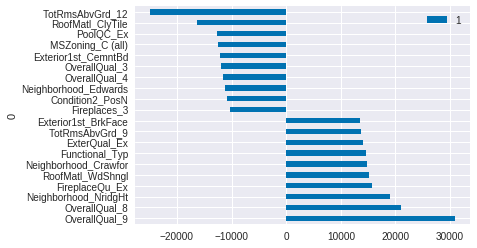

In [83]:
best_r2['model'].apply(plot_coef)

7    Axes(0.125,0.125;0.775x0.755)
Name: model, dtype: object

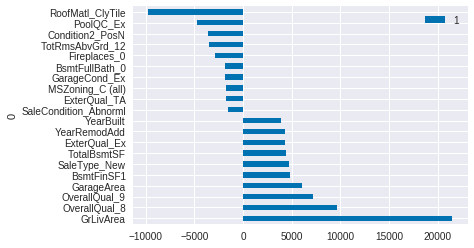

In [84]:
best_mae['model'].apply(plot_coef)

#### Which features add / take away most value from a home?

Having a high overall quality (of 8&9) is adds the most value, followed by being in the Northridge Heights neighborhood. Less important are having a good quality fireplace, having wood shingles, being in the Crawford neighborhood, having excellent external quality, etc.

Weirdly enough, having 12 rooms above ground takes away the most value. After that, people apparently dislike clay tile roofs, excellent pools, being in the C class of MSZoning, and having a cement exterior. The first three might be features that I should have engineered or removed, however. They are unlikely to affect my valuation of a house much less, in the case of the pools, decrease it.

# (Optional) Informing Business Value

Interpreting our work for a non-technical audience is a vital skill that every good Data Scientist must cultivate.  At the end of the day, our work must be informative to business process so connecting our detailed efforts to a high level strategy is critical.

We've established a few businesses cases that you should assert some explanation and advise best strategy through a model of your choice.  Also call out any exploratory analysis and reasoning for any recommendation.

##### For each question:
* Plot relevant data
* Fit a new model or use a previous  model
* Plot relevant coefficients


#### (Optional) Case 1: Which features add / take away most value from a home?

You just explained which coeffients add / take away most value, technically, but can you explain this in a non-technical manner?  Also, emphasize _why_ in your explanation.

- Choose a few examples and explain why the coefficients describe the target value of the property.

#### (Optional) Case 2: Can you identify any abnormally priced houses?
We might consider these being properties that are over or under predicted by price. Can you make sense of when and why these are over and under predicted?

#### (Optional) Case 3:  Which houses are good investments?

Which criteria would you look at?  How sure can you be of your assumptions?  Give precise metrics but also give a concise recommendation that is non-technical that communicates the risks of your anlaysis.

#### (Optional) Case 4:  Which houses are good investments (extended)?
One idea that is common in the real-estate invement community is called "flipping".  This usually entails buying a property with "changable" charactaristics that can be upgraded.  Examples of changable or "upgradable" features include:  A garage, a kitchen, etc.

Can you give us an idea of investments opportunities considering "upgradable" features?  You will have to explore this idea on your own and possibly do a little research for subject matter expertise.

- Some features of a house are worth more than others
- Some features can't be upgraded (ie: square footage)